# Model Building

20 Words to train (daily used words): <br>
"Family", "Friends", "Work", "School", "Home", "Car", "Happy", "Sad", "Play", "Help", "Eat", "Drink", "Sleep", "Sorry", "Computer", "Money", "Phone", "Clothe", "Me", "Stop"

## Import Library

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Keypoint using Mediapipe Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
# Color conversion 
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB to BGR
    return image, results

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1)
                             ) 

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

print(results)

<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [6]:
draw_styled_landmarks(image, results)

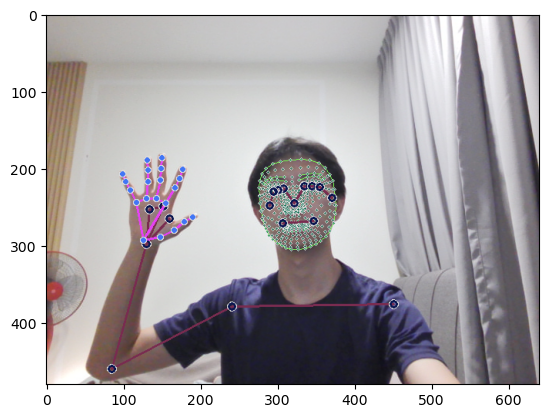

In [7]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Extract Keypoint Values

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## Setup Folders for Data Collection

In [7]:
# Desired path for data
desired_path = "C:\\Users\\erwin\\Desktop\\ASL_Translation_FYP"

# Creating a subfolder for MP_Data within the desired path
DATA_PATH = os.path.join(desired_path, 'ASL_Dataset') 

# Actions that we try to detect
actions = np.array(["Family", "Friends", "Work", "School", "Home", "Car", "Happy", "Sad", "Play", 
                    "Help", "Eat", "Drink", "Sleep", "Sorry", "Computer", "Money", "Phone", "Clothe", "Me", "Stop"])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [13]:
for action in actions: 
    action_path = os.path.join(DATA_PATH, action)
    
    # Check if the action directory exists, create if not
    if not os.path.exists(action_path):
        os.makedirs(action_path)
        dirmax = 0
    else:
        # List directories and find the max
        try:
            dirmax = np.max(np.array(os.listdir(action_path)).astype(int))
        except ValueError:  # This occurs if there are no directories
            dirmax = 0

    for sequence in range(1, no_sequences + 1):
        try: 
            os.makedirs(os.path.join(action_path, str(dirmax + sequence)))
        except:
            pass
            

## Data Collection

In [21]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [19]:
cap.release()
cv2.destroyAllWindows()

## Data Preparation and Create Labels and Features

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
label_map = {label:num for num, label in enumerate(actions)}

In [10]:
label_map

{'Family': 0,
 'Friends': 1,
 'Work': 2,
 'School': 3,
 'Home': 4,
 'Car': 5,
 'Happy': 6,
 'Sad': 7,
 'Play': 8,
 'Help': 9,
 'Eat': 10,
 'Drink': 11,
 'Sleep': 12,
 'Sorry': 13,
 'Computer': 14,
 'Money': 15,
 'Phone': 16,
 'Clothe': 17,
 'Me': 18,
 'Stop': 19}

In [11]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [12]:
np.array(sequences).shape

(800, 30, 1662)

In [13]:
np.array(labels).shape

(800,)

In [14]:
X = np.array(sequences)

In [15]:
X.shape

(800, 30, 1662)

In [16]:
y = to_categorical(labels).astype(int)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build and Train LSTM Neutral Network 

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [50]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [5]:
LSTM_model = Sequential()
LSTM_model = Sequential()
LSTM_model.add(LSTM(64, return_sequences=True, input_shape=(30,1662)))
LSTM_model.add(LSTM(128, return_sequences=True))
LSTM_model.add(LSTM(64))
LSTM_model.add(Dense(64, activation='relu'))
LSTM_model.add(Dense(32, activation='relu'))
LSTM_model.add(Dense(actions.shape[0], activation='softmax'))

c:\Users\erwin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'actions' is not defined

In [53]:
LSTM_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [54]:
LSTM_model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - categorical_accuracy: 0.0381 - loss: 3.0088
Epoch 2/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.0631 - loss: 2.9970
Epoch 3/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.0387 - loss: 2.9961
Epoch 4/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.0979 - loss: 2.9441
Epoch 5/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0984 - loss: 2.7836
Epoch 6/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.1028 - loss: 2.4706
Epoch 7/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.1168 - loss: 2.4086
Epoch 8/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.0551 - loss: 3.5169
Epoch 9/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.0511 - loss: 3.0010
Epoch 10/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0658 - loss: 2.9955
Epoch 11/

In [55]:
LSTM_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,791,710 (6.83 MB)

 Trainable params: 597,236 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,194,474 (4.56 MB)

## Evaluation using Confusin Matrix and Accuracy - LSTM

In [56]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report, confusion_matrix

In [57]:
yhat = LSTM_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


In [58]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [59]:
confusion_matrix(ytrue, yhat)

array([[ 3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  8,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  2,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  4,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  1,  1,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0

In [60]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[157,   0],
        [  0,   3]],

       [[145,   6],
        [  1,   8]],

       [[149,   1],
        [  3,   7]],

       [[150,   4],
        [  1,   5]],

       [[151,   0],
        [  0,   9]],

       [[153,   0],
        [  3,   4]],

       [[152,   0],
        [  1,   7]],

       [[153,   0],
        [  0,   7]],

       [[148,   4],
        [  2,   6]],

       [[146,   1],
        [  3,  10]],

       [[154,   0],
        [  0,   6]],

       [[150,   1],
        [  0,   9]],

       [[148,   0],
        [  0,  12]],

       [[154,   1],
        [  0,   5]],

       [[153,   0],
        [  0,   7]],

       [[151,   1],
        [  3,   5]],

       [[149,   0],
        [  1,  10]],

       [[150,   1],
        [  3,   6]],

       [[155,   0],
        [  0,   5]],

       [[151,   1],
        [  0,   8]]], dtype=int64)

In [61]:
print(accuracy_score(ytrue, yhat))

0.86875


In [62]:
print(classification_report(ytrue, yhat, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.57      0.89      0.70         9
           2       0.88      0.70      0.78        10
           3       0.56      0.83      0.67         6
           4       1.00      1.00      1.00         9
           5       1.00      0.57      0.73         7
           6       1.00      0.88      0.93         8
           7       1.00      1.00      1.00         7
           8       0.60      0.75      0.67         8
           9       0.91      0.77      0.83        13
          10       1.00      1.00      1.00         6
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00        12
          13       0.83      1.00      0.91         5
          14       1.00      1.00      1.00         7
          15       0.83      0.62      0.71         8
          16       1.00      0.91      0.95        11
          17       0.86    

## Save Model

In [ ]:
LSTM_model.save('LSTM_Model.h5')
LSTM_model.save('LSTM_Model.keras')

## Build and Train CNN

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard

In [35]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [36]:
CNN_model = Sequential()
CNN_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30,1662)))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dense(actions.shape[0], activation='softmax'))

c:\Users\erwin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [37]:
CNN_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [38]:
CNN_model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - categorical_accuracy: 0.0455 - loss: 3.0732
Epoch 2/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.0591 - loss: 2.9701
Epoch 3/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.1182 - loss: 2.7872
Epoch 4/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.1192 - loss: 2.5732
Epoch 5/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.1437 - loss: 2.4274
Epoch 6/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.1856 - loss: 2.2574
Epoch 7/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2038 - loss: 2.1243
Epoch 8/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.2160 - loss: 2.0801
Epoch 9/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.2612 - loss: 2.0229
Epoch 10/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.2859 - loss: 1.9007
Epoch 11/2000
20/20

In [39]:
CNN_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │       319,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187,486 (4.53 MB)

 Trainable params: 395,828 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 791,658 (3.02 MB)

## Evaluation using Confusion Matrix and Accuracy - CNN

In [16]:
#CNN_model.load_weights("CNN_Model.h5")

In [40]:
yhat = CNN_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


In [41]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [42]:
confusion_matrix(ytrue, yhat)

array([[ 3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         1,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0

In [43]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[156,   1],
        [  0,   3]],

       [[150,   1],
        [  0,   9]],

       [[149,   1],
        [  2,   8]],

       [[153,   1],
        [  1,   5]],

       [[151,   0],
        [  0,   9]],

       [[153,   0],
        [  1,   6]],

       [[152,   0],
        [  0,   8]],

       [[153,   0],
        [  0,   7]],

       [[149,   3],
        [  0,   8]],

       [[147,   0],
        [  0,  13]],

       [[154,   0],
        [  0,   6]],

       [[150,   1],
        [  0,   9]],

       [[148,   0],
        [  0,  12]],

       [[155,   0],
        [  0,   5]],

       [[153,   0],
        [  0,   7]],

       [[150,   2],
        [  2,   6]],

       [[148,   1],
        [  2,   9]],

       [[151,   0],
        [  3,   6]],

       [[155,   0],
        [  0,   5]],

       [[152,   0],
        [  0,   8]]], dtype=int64)

In [44]:
print(accuracy_score(ytrue, yhat))

0.93125


In [46]:
print(classification_report(ytrue, yhat, zero_division=0))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.90      1.00      0.95         9
           2       0.89      0.80      0.84        10
           3       0.83      0.83      0.83         6
           4       1.00      1.00      1.00         9
           5       1.00      0.86      0.92         7
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         7
           8       0.73      1.00      0.84         8
           9       1.00      1.00      1.00        13
          10       1.00      1.00      1.00         6
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         7
          15       0.75      0.75      0.75         8
          16       0.90      0.82      0.86        11
          17       1.00    

## Save Model - CNN

In [ ]:
CNN_model.save('CNN_Model.h5')
CNN_model.save('CNN_Model.keras')